In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import gpjax as gpx
import jax.numpy as jnp
import kohgpjax as kgx
import jax

from kohgpjax.parameters import ModelParameters

from models.sin_a import Model, get_ModelParameterPriorDict
import dataloader

from plotting import (
    gen_x_test_data,
    gen_plot_test_data,
    gen_GP_test_data,
    plot_f_eta,
    plot_f_delta,
    plot_f_zeta,
    plot_pairwise_samples,
    plot_posterior_chains_with_priors,
    plot_sim_sample,
    # plot_time_vs_sim_output,
)

from data.true_funcs import (
    discrepancy,
    eta,
    TrueParams,
    zeta,
)


TP = TrueParams()
num_calib_params=1

/Users/jamesbriant/miniforge3/envs/py311gpjax011/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load observations and simulation outputs

In [2]:
kohdataset, tminmax, ycmean = dataloader.load(
    sim_file_path_csv=f"data/sim-a.csv",
    obs_file_path_csv=f"data/obs-a.csv",
    num_calib_params=num_calib_params,
)

Load posterior samples

In [3]:
chains = az.from_netcdf("chains/sin-a-W80-N50-Nsim250.nc")
# print(az.summary(chains))

# 2.2 Extract the transformed parameters
posterior_means = chains.posterior.mean()

print(f"Posterior means: {posterior_means}\n")

posterior_means_GP = posterior_means.copy()
for i in range(num_calib_params):
    tmin, tmax = tminmax[f"theta_{i}"]
    # transform the theta values back to the [0,1] scale for the GP model
    theta_i_gp = (posterior_means[f"theta_{i}"].values - tmin) / (tmax - tmin)
    posterior_means_GP[f"theta_{i}"] = theta_i_gp
    print(f"Posterior theta_{i} mean (GP scale): {theta_i_gp}")

Posterior means: <xarray.Dataset> Size: 56B
Dimensions:                  ()
Data variables:
    delta_lengthscale_x_0    float64 8B 15.02
    delta_precision          float64 8B 22.39
    epsilon_precision        float64 8B 402.6
    eta_lengthscale_theta_0  float64 8B 4.147
    eta_lengthscale_x_0      float64 8B 0.8444
    eta_precision            float64 8B 0.8545
    theta_0                  float64 8B 0.3989

Posterior theta_0 mean (GP scale): 0.753761879254654


In [ ]:
xpred = gen_x_test_data()
print(xpred.shape)

# 3.2 Get the theta vector and tile for array
theta_vec_plot = TP.get_theta().squeeze()
theta_vec_GP = TP.get_theta().squeeze()
for i in range(num_calib_params):
    theta_vec_plot[i] = posterior_means[f"theta_{i}"].values
    theta_vec_GP[i] = posterior_means_GP[f"theta_{i}"].values

# 3.3 Full x_test array
x_test, theta_arr_plot = gen_plot_test_data(
    theta_vec=theta_vec_plot,
    num_points=1000,
)
print(x_test.shape)
print(theta_arr_plot.shape)

# 3.4 extract variables used for GP
test_GP = gen_GP_test_data(
    theta_vec=theta_vec_GP,
    num_calib_params=num_calib_params,
)
print(test_GP.shape)

# 3.5 Generate the full dataset
dataset = kohdataset.get_dataset(theta_vec_GP[:num_calib_params].reshape(1, -1))
print(dataset)

(1000, 2)
(1000, 2)
(1000, 5)
(1000, 2)
Dataset(Number of observations: 3100 - Input dimension: 2)


In [5]:
prior_dict = get_ModelParameterPriorDict(tminmax)
model_parameters = ModelParameters(prior_dict=prior_dict)

# 4.3 Create the model instance
model = Model(
    model_parameters=model_parameters,
    kohdataset=kohdataset,
)

# 4.4 Get the parameters into the correct format
prior_leaves, prior_tree = jax.tree.flatten(prior_dict)
# cannot assume jax tree and arviz/xarray ordering is the same
GP_params_flat = {p.name: posterior_means[p.name].values for p in prior_leaves}
for i in range(num_calib_params):
    tmin, tmax = tminmax[f"theta_{i}"]
    GP_params_flat[f"theta_{i}"] = (GP_params_flat[f"theta_{i}"] - tmin) / (tmax - tmin)  # Normalise theta_i to [0, 1]

thetas = jnp.array([GP_params_flat[f"theta_{i}"] for i in range(num_calib_params)])
GP_params = jax.tree.unflatten(prior_tree, GP_params_flat.values())

# 4.5 Build the GP posterior
GP_posterior = model.GP_posterior(GP_params)
# print(f"GP posterior: {GP_posterior}")

Creating ModelParameterPriorDict for sin-a model...
A0: -0.02347600873936904, B0: 1.0205447979783209


In [6]:
# 5 Generating the predictions
# 5.1 Predict the eta, zeta, and obs values
print("Generating predictions...")
eta_pred = GP_posterior.predict_eta(test_GP, dataset)
zeta_pred = GP_posterior.predict_zeta(test_GP, dataset)
obs_pred = GP_posterior.predict_obs(test_GP, dataset)

Generating predictions...


In [7]:
eta_pred_m = eta_pred.mean
eta_pred_cov = eta_pred.covariance_matrix

zeta_pred_m = zeta_pred.mean
zeta_pred_cov = zeta_pred.covariance_matrix

obs_pred_m = obs_pred.mean
obs_pred_cov = obs_pred.covariance_matrix

# 5.2 Model discrepancy
delta_gp_m = zeta_pred_m - eta_pred_m
delta_gp_cov = zeta_pred_cov + eta_pred_cov

# Plot

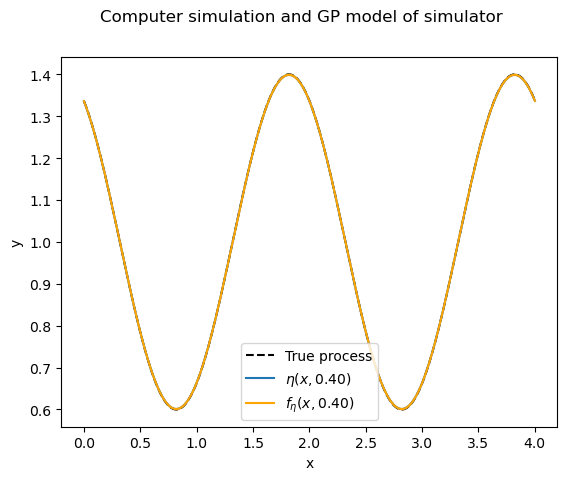

In [8]:
fig, ax = plot_f_eta(
    x_test=x_test,
    test_GP=test_GP,
    thetas_test=theta_arr_plot,
    true_params=TP,
    num_calib_params=num_calib_params,
    eta=eta,
    GP_eta=eta_pred,
    y_translation=ycmean,  # Add the mean of yc to center the observations
)
plt.show()

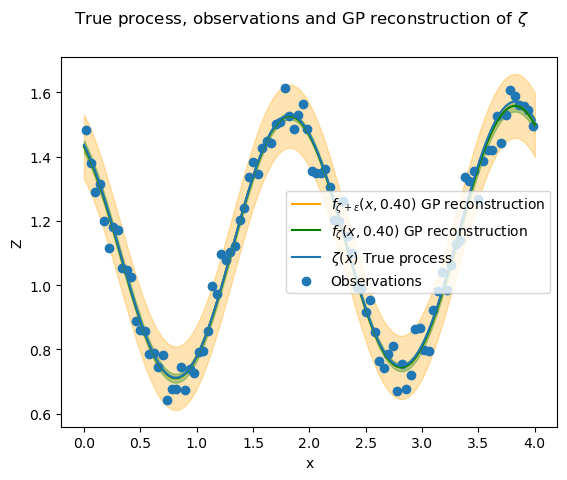

In [9]:
plot_f_zeta(
    x_test=x_test,
    test_GP=test_GP,
    thetas_test=theta_arr_plot,
    num_calib_params=num_calib_params,
    zeta=zeta,
    GP_zeta=zeta_pred,
    GP_zeta_epsilon=obs_pred,
    scatter_xf=kohdataset.Xf,
    scatter_yf=kohdataset.z,
    y_translation=ycmean,  # Add the mean of yc to center the observations
)
plt.show()

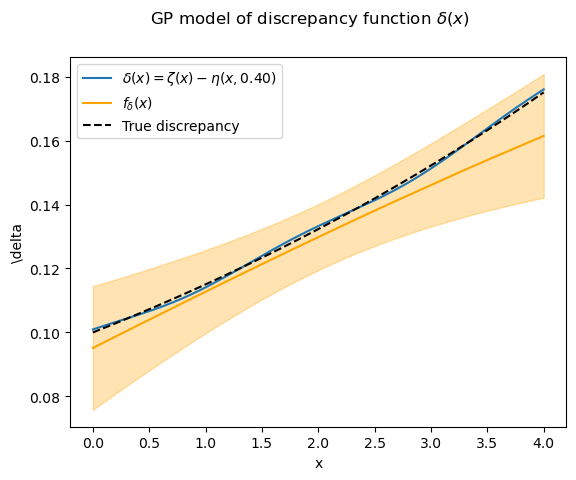

In [10]:
plot_f_delta(
    x_test=x_test,
    test_GP=test_GP,
    thetas_test=theta_arr_plot,
    num_calib_params=num_calib_params,
    eta=eta,
    zeta=zeta,
    delta=discrepancy,
    delta_gp_mean=delta_gp_m,
    delta_gp_cov=delta_gp_cov,
)
plt.show()

Compare $f_\eta$, $f_\zeta$ and $f_{\zeta+\epsilon}$

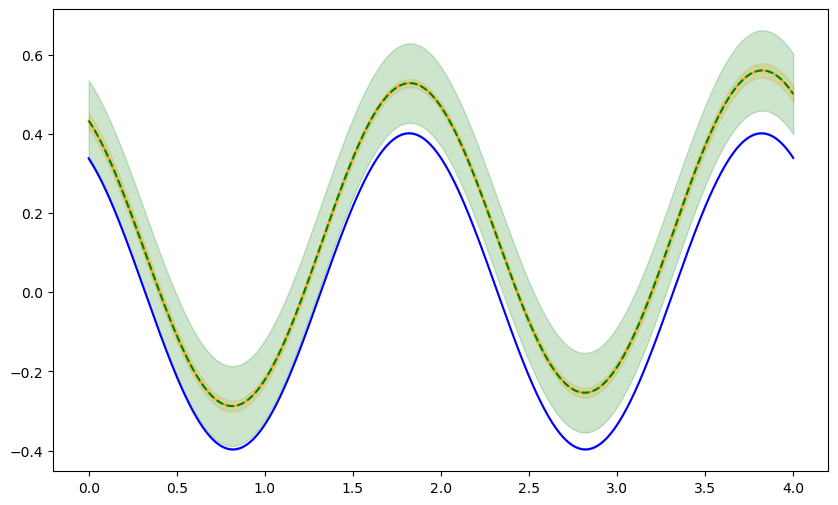

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(
    test_GP[:, 0],
    eta_pred_m,
    label="GP posterior mean of $f_\\eta$",
    color="blue",
)
ax.fill_between(
    test_GP[:, 0],
    eta_pred_m - 2 * jnp.sqrt(jnp.diag(eta_pred_cov)),
    eta_pred_m + 2 * jnp.sqrt(jnp.diag(eta_pred_cov)),
    alpha=0.2,
    color="blue",
)
ax.plot(
    test_GP[:, 0],
    zeta_pred_m,
    label="GP posterior mean of $f_\\zeta$",
    color="orange",
)
ax.fill_between(
    test_GP[:, 0],
    zeta_pred_m - 2 * jnp.sqrt(jnp.diag(zeta_pred_cov)),
    zeta_pred_m + 2 * jnp.sqrt(jnp.diag(zeta_pred_cov)),
    alpha=0.2,
    color="orange",
)
ax.plot(
    test_GP[:, 0],
    obs_pred_m,
    label="GP posterior mean of $f_{\\zeta + \\epsilon}$",
    color="green",
    linestyle="--",
)
ax.fill_between(
    test_GP[:, 0],
    obs_pred_m - 2 * jnp.sqrt(jnp.diag(obs_pred_cov)),
    obs_pred_m + 2 * jnp.sqrt(jnp.diag(obs_pred_cov)),
    alpha=0.2,
    color="green",
)
plt.show()

In [12]:
diff_pred_m = zeta_pred_m - eta_pred_m
diff_pred_cov = zeta_pred_cov + eta_pred_cov

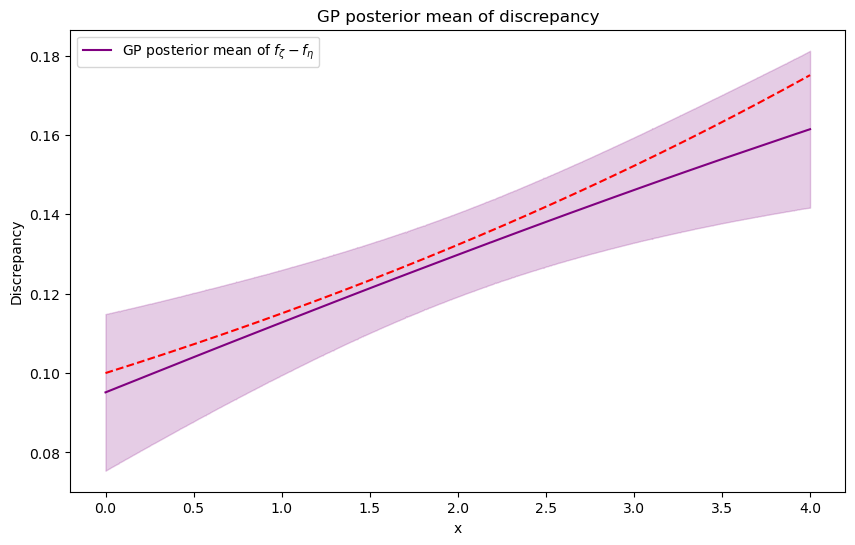

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(
    test_GP[:, 0],
    diff_pred_m,
    label="GP posterior mean of $f_\\zeta - f_\\eta$",
    color="purple",
)
ax.fill_between(
    test_GP[:, 0],
    diff_pred_m - 2 * jnp.sqrt(jnp.diag(diff_pred_cov)),
    diff_pred_m + 2 * jnp.sqrt(jnp.diag(diff_pred_cov)),
    alpha=0.2,
    color="purple",
)
ax.set_title("GP posterior mean of discrepancy")
ax.set_xlabel("x")
ax.set_ylabel("Discrepancy")
ax.legend()
ax.plot(
    test_GP[:, 0],
    discrepancy(
        x_test,
        # theta_arr,
    ),
    label="True discrepancy",
    color="red",
    linestyle="--",
)
plt.show()

The discrepancy process has been learnt correctly - approximated as a linear process (very long lengthscale). The uncertainty is also correct.

We know the uncertainty for the emulator is too small, or rather the predictor has learnt the incorrect value.